<ipython-input-15-3de6ae12222d>:14: ComplexWarning: Casting complex values to real discards the imaginary part
  d_prime[0] = d[0]/b[0]
<ipython-input-15-3de6ae12222d>:19: ComplexWarning: Casting complex values to real discards the imaginary part
  d_prime[i] = (d[i] - a[i-1]*d_prime[i-1])/denominator
<ipython-input-15-3de6ae12222d>:21: ComplexWarning: Casting complex values to real discards the imaginary part
  d_prime[-1] = (d[-1] - a[-2]*d_prime[-2])/(b[-1] - a[-2]*c_prime[-2])


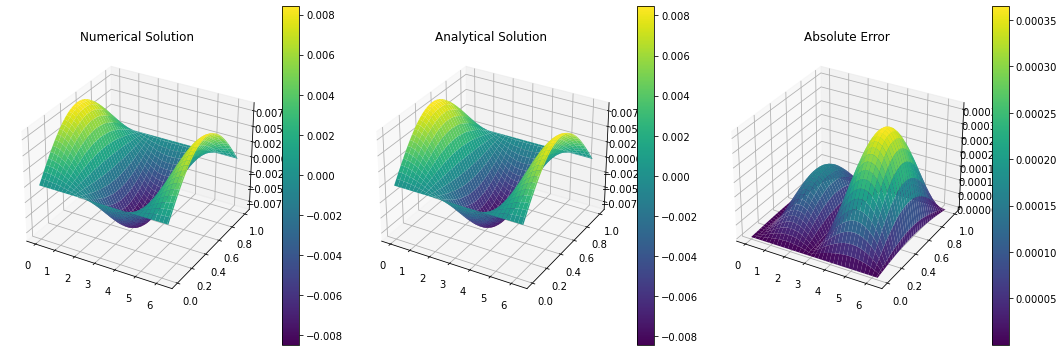


Grid size: 101x101
Numerical solution time: 0.039 seconds
Analytical solution time: 0.000 seconds
Maximum absolute error: 3.66e-04
RMS error: 1.45e-04


In [15]:
import numpy as np
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

def tdma_solver(a, b, c, d):
    """TDMA solver (same as before)"""
    n = len(d)
    c_prime = np.zeros(n-1)
    d_prime = np.zeros(n)
    
    c_prime[0] = c[0]/b[0]
    d_prime[0] = d[0]/b[0]
    
    for i in range(1, n-1):
        denominator = (b[i] - a[i-1]*c_prime[i-1])
        c_prime[i] = c[i]/denominator
        d_prime[i] = (d[i] - a[i-1]*d_prime[i-1])/denominator
    
    d_prime[-1] = (d[-1] - a[-2]*d_prime[-2])/(b[-1] - a[-2]*c_prime[-2])
    
    x = np.zeros(n)
    x[-1] = d_prime[-1]
    
    for i in range(n-2, -1, -1):
        x[i] = d_prime[i] - c_prime[i]*x[i+1]
    
    return x

def solve_poisson_1d(f, kx, dz, nz):
    """Solve 1D Poisson equation for given Fourier mode"""
    # Set up tridiagonal system
    a = np.ones(nz-1)/dz**2
    b = -2*np.ones(nz)/dz**2 - kx**2
    c = np.ones(nz-1)/dz**2
    
    # Solve system
    sol = tdma_solver(a, b, c, f)
    return sol

def biharmonic_solver(x, z, L, H):
    """
    Solves biharmonic equation by solving Poisson twice
    """
    nx, nz = len(x)-1, len(z)-1
    X, Z = np.meshgrid(x, z)
    dz = H/nz
    
    # Source term
    source = np.sin(np.pi*Z/H)*np.cos(2*np.pi*X/L)
    
    # Take FFT in x-direction
    source_hat = fft(source, axis=1)/(nx+1)
    phi_hat = np.zeros_like(source_hat, dtype=complex)
    
    # Wavenumbers for x direction
    kx = 2*np.pi*np.fft.fftfreq(nx+1, L/(nx+1))
    
    # For each Fourier mode
    for k in range(nx+1):
        if abs(kx[k]) < 1e-10:
            continue
            
        # First solve ∇²ψ = f
        psi = solve_poisson_1d(source_hat[1:-1,k], kx[k], dz, nz-1)
        
        # Then solve ∇²φ = ψ
        phi_hat[1:-1,k] = solve_poisson_1d(psi, kx[k], dz, nz-1)
    
    # Take inverse FFT
    phi = np.real(ifft(phi_hat, axis=1))*(nx+1)
    
    # Apply boundary conditions
    phi[0,:] = 0
    phi[-1,:] = 0
    
    return phi

def analytical_solution(x, z, L, H):
    """Analytical solution (same as before)"""
    X, Z = np.meshgrid(x, z)
    kx = 2*np.pi/L
    kz = np.pi/H
    return np.sin(kz*Z)*np.cos(kx*X)/(kx**4 + 2*kx**2*kz**2 + kz**4)

def solve_and_compare(nx=100, nz=100):
    """Compare numerical and analytical solutions"""
    L = 2*np.pi
    H = 1.0
    x = np.linspace(0, L, nx+1)
    z = np.linspace(0, H, nz+1)
    
    t0 = time.time()
    numerical = biharmonic_solver(x, z, L, H)
    numerical_time = time.time() - t0
    
    t0 = time.time()
    exact = analytical_solution(x, z, L, H)
    analytical_time = time.time() - t0
    
    # Compute errors
    abs_error = np.abs(numerical - exact)
    max_error = np.max(abs_error)
    rms_error = np.sqrt(np.mean(abs_error**2))
    
    # Plot results
    X, Z = np.meshgrid(x, z)
    fig = plt.figure(figsize=(15, 5))
    
    ax1 = fig.add_subplot(131, projection='3d')
    surf1 = ax1.plot_surface(X, Z, numerical, cmap='viridis')
    ax1.set_title('Numerical Solution')
    plt.colorbar(surf1, ax=ax1)
    
    ax2 = fig.add_subplot(132, projection='3d')
    surf2 = ax2.plot_surface(X, Z, exact, cmap='viridis')
    ax2.set_title('Analytical Solution')
    plt.colorbar(surf2, ax=ax2)
    
    ax3 = fig.add_subplot(133, projection='3d')
    surf3 = ax3.plot_surface(X, Z, abs_error, cmap='viridis')
    ax3.set_title('Absolute Error')
    
    plt.colorbar(surf3, ax=ax3)
    
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nGrid size: {nx+1}x{nz+1}")
    print(f"Numerical solution time: {numerical_time:.3f} seconds")
    print(f"Analytical solution time: {analytical_time:.3f} seconds")
    print(f"Maximum absolute error: {max_error:.2e}")
    print(f"RMS error: {rms_error:.2e}")

if __name__ == "__main__":
    solve_and_compare(nx=100, nz=100)